In [1]:
import numpy as np
import ltspice
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import division
import re

## Functions to load and plot .raw files

In [2]:
def plot_dynamic(arrs, plots_metadata, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False, num_plots=None):
    plot_number = 1  # Initialize plot number before the loop
    for data, meta in zip(arrs, plots_metadata):
        n_vars = int(meta[b'no. variables']) - 1
        if num_plots is not None:
            n_vars = min(n_vars, num_plots)  # Limit the number of plots if num_plots is set

        x_var_name = meta['varnames'][0]
        x_data = data[x_var_name]  # Assume x-data is positive and linear

        fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))
        if n_vars == 1:
            axes = [axes]  # Make axes iterable if only one plot

        for i in range(1, n_vars + 1):
            ax = axes[i-1 if n_vars > 1 else 0]
            y_var_name = meta['varnames'][i]
            y_data = data[y_var_name]
            
            label = y_var_name
            y_data_plot = y_data  # Assume the data is already correctly formatted for plotting
            
            ax.plot(x_data, y_data_plot, label=label)
            ax.ticklabel_format(style='plain', axis='both', useOffset=False)
            ax.set_xlabel(f'{x_var_name} ({meta["varunits"][0]})')
            ax.set_ylabel(f'{y_var_name} ({meta["varunits"][i]})')
            ax.set_xscale(x_scale)
            ax.set_yscale(y_scale)
            ax.set_title(f'{y_var_name} vs. {x_var_name} ({plot_number})')
            ax.legend()
            ax.grid(True)

            if mark_cutoff and is_data_in_dB:
                max_gain = np.max(y_data_plot)
                db3_drop = max_gain - 3
                max_gain_index = np.argmax(y_data_plot)

                lower_indices = np.where(y_data_plot[:max_gain_index] <= db3_drop)[0]
                upper_indices = np.where(y_data_plot[max_gain_index:] <= db3_drop)[0] + max_gain_index
                
                if lower_indices.size > 0:
                    lower_cutoff_frequency = x_data[lower_indices[-1]]
                    ax.axvline(x=lower_cutoff_frequency, color='red', linestyle='--', label='Lower Cutoff Frequency')
                else:
                    lower_cutoff_frequency = 0
                if upper_indices.size > 0:
                    upper_cutoff_frequency = x_data[upper_indices[0]]
                    ax.axvline(x=upper_cutoff_frequency, color='blue', linestyle='--', label='Upper Cutoff Frequency')
                else:
                    upper_cutoff_frequency = 0
                
                ax.axhline(y=db3_drop, color='green', linestyle='--', label='-3 dB line')
                ax.legend()

            plot_number += 1  # Increment plot number for each subplot
            if num_plots is not None and plot_number > num_plots:
                break  # Exit the loop early if the maximum number of plots has been reached

        plt.tight_layout()
        plt.show()
        if mark_cutoff and is_data_in_dB:
            return max_gain.real, lower_cutoff_frequency.real, upper_cutoff_frequency.real

        
BSIZE_SP = 512 # Max size of a line of data; we don't want to read the
               # whole file to find a line, in case file does not have
               # expected structure.
MDATA_LIST = [b'title', b'date', b'plotname', b'flags', b'no. variables',
              b'no. points', b'dimensions', b'command', b'option']

def rawread(fname: str):
    """Read ngspice binary raw files. Return tuple of the data, and the
    plot metadata. The dtype of the data contains field names. This is
    not very robust yet, and only supports ngspice.
    >>> darr, mdata = rawread('test.py')
    >>> darr.dtype.names
    >>> plot(np.real(darr['frequency']), np.abs(darr['v(out)']))
    """
    # Example header of raw file
    # Title: rc band pass example circuit
    # Date: Sun Feb 21 11:29:14  2016
    # Plotname: AC Analysis
    # Flags: complex
    # No. Variables: 3
    # No. Points: 41
    # Variables:
    #         0       frequency       frequency       grid=3
    #         1       v(out)  voltage
    #         2       v(in)   voltage
    # Binary:
    fp = open(fname, 'rb')
    count = 0
    arrs = []
    plots = []
    plot = {}
    while (True):
        try:
            mdata = fp.readline(BSIZE_SP).split(b':', maxsplit=1)
        except:
            raise
        if len(mdata) == 2:
            if mdata[0].lower() in MDATA_LIST:
                plot[mdata[0].lower()] = mdata[1].strip()
            if mdata[0].lower() == b'variables':
                nvars = int(plot[b'no. variables'])
                npoints = int(plot[b'no. points'])
                plot['varnames'] = []
                plot['varunits'] = []
                for varn in range(nvars):
                    varspec = (fp.readline(BSIZE_SP).strip()
                               .decode('ascii').split())
                    assert(varn == int(varspec[0]))
                    plot['varnames'].append(varspec[1])
                    plot['varunits'].append(varspec[2])
            if mdata[0].lower() == b'binary':
                rowdtype = np.dtype({'names': plot['varnames'],
                                     'formats': [np.complex_ if b'complex'
                                                 in plot[b'flags']
                                                 else np.float_]*nvars})
                # We should have all the metadata by now
                arrs.append(np.fromfile(fp, dtype=rowdtype, count=npoints))
                plots.append(plot)
                plot = {} # reset the plot dict
                fp.readline() # Read to the end of line
        else:
            break
    return (arrs, plots)

# Simulation results v3

## Store simulation?

In [3]:
store_sim = False

## Loading values of parameters

In [4]:
# Arrays to store the results of the simulations
param_values = np.zeros(19)    # order: Vdd, Wn, Ln, Wp, Lp, R1_Wn, R1_Ln, R1_Vg, R2_Wn, R2_Ln, R2_Vg, Wc1, Lc1, MFc1, C_1, Wc2, Lc2, Mfc2, C_2 Vdc
results_sim = np.zeros(4)    # order: gain (in dB), cut-off, noise, power

def extract_spice_params(file_path):
    # Parameters to extract
    params = {
        'Vdd': None,
        'Wn': None,
        'Ln': None,
        'Wp': None,
        'Lp': None,
        'R1_Wn': None,
        'R1_Ln': None,
        'R1_Vg': None,
        'R2_Wn': None,
        'R2_Wp': None,
        'R2_Vg': None,
        'Wc1': None,
        'Lc1': None,
        'MFc1': None,
        'C_1': None,
        'Wc2': None,
        'Lc2': None,
        'MFc2': None,
        'C_2': None,
        'Vdc': None
    }
    
    # Open and read the SPICE file
    with open(file_path, 'r') as file:
        content = file.readlines()
    
    # Regex patterns to capture values
    patterns = {
        'Vdd': r'VP VCC GND dc (\d+\.?\d*)',
        'Vdc': r'Vin in GND (\d+\.?\d*) ac',
        'Wn': r'x1 VS1 VD1 VCC VSS not W_N=(\d+\.?\d*) L_N=',  # Adjusted to target the specific line
        'Ln': r'x1 VS1 VD1 VCC VSS not .*L_N=(\d+\.?\d*) W_P=',  # Adjusted to target the specific line
        'Wp': r'x1 VS1 VD1 VCC VSS not .*W_P=(\d+\.?\d*)',
        'Lp': r'x1 VS1 VD1 VCC VSS not .*L_P=(\d+\.?\d*) m=',  # Adjusted to target the specific line
        'R1_Wn': r'XM1 .+ W=(\d+\.?\d*) nf=',
        'R1_Ln': r'XM1 .+ L=(\d+\.?\d*) W=',
        'R1_Vg': r'VG1 VG1 GND dc (\d+\.?\d*)',
        'R2_Wn': r'XM2 .+ W=(\d+\.?\d*) nf=',
        'R2_Wp': r'XM2 .+ L=(\d+\.?\d*) W=',
        'R2_Vg': r'VG2 VG2 GND dc (\d+\.?\d*)',
        'Wc1': r'XC1 .+ W=(\d+\.?\d*) L=',
        'Lc1': r'XC1 .+ L=(\d+\.?\d*)',
        'MFc1': r'XC1 .+ MF=(\d+\.?\d*) m=',
        'Wc2': r'XC2 .+ W=(\d+\.?\d*) L=',
        'Lc2': r'XC2 .+ L=(\d+\.?\d*)',
        'MFc2': r'XC2 .+ MF=(\d+\.?\d*) m='
    }
    
    # Extract parameters
    for line in content:
        for key, pattern in patterns.items():
            match = re.search(pattern, line)
            if match:
                params[key] = float(match.group(1))

    # Calculate capacitance using the given formula
    if params['Wc1'] and params['Lc1'] and params['MFc1']:
        params['C_1'] = params['MFc1'] * params['Wc1'] * params['Lc1']  # Simple multiplication
    
    # Calculate capacitance using the given formula
    if params['Wc2'] and params['Lc2'] and params['MFc2']:
        params['C_2'] = params['MFc2'] * params['Wc2'] * params['Lc2']  # Simple multiplication

    # Convert to NumPy array
    param_values = np.array([params[key] for key in params], dtype=float)
    
    return param_values

# Usage
file_path = "../../netlist/tb_inv_sky130_a_v3.spice"
param_values = extract_spice_params(file_path)
print("The values of the parameters are: ")
print("Vdd = ", param_values[0])
print("Wn = ", param_values[1])
print("Ln = ", param_values[2])
print("Wp = ", param_values[3])
print("Lp = ", param_values[4])
print("R1_Wn = ", param_values[5])
print("R1_Ln = ", param_values[6])
print("R1_Vg = ", param_values[7])
print("R2_Wn = ", param_values[8])
print("R2_Ln = ", param_values[9])
print("R2_Vg = ", param_values[10])
print("Wc1 = ", param_values[11])
print("Lc1 = ", param_values[12])
print("MFc1 = ", param_values[13])
param_values[14] = param_values[13] * (param_values[11] * param_values[12] * 2e-15 + (param_values[11] + param_values[12]) * 0.38e-15)
print("C_1 = ", param_values[14])
print("Wc2 = ", param_values[15])
print("Lc2 = ", param_values[16])
print("MFc2 = ", param_values[17])
param_values[18] = param_values[17] * (param_values[16] * param_values[15] * 2e-15 + (param_values[16] + param_values[15]) * 0.38e-15)
print("C_2 = ", param_values[18])
print("Vdc = ", param_values[19])

R1_value = param_values[7]
R2_value = param_values[10]
C1_value = param_values[14]*1e15   # Convert to fF
C2_value = param_values[18]*1e15    # Convert to fF

The values of the parameters are: 
Vdd =  1.125
Wn =  250.0
Ln =  1.0
Wp =  200.0
Lp =  0.25
R1_Wn =  0.5
R1_Ln =  0.15
R1_Vg =  0.725
R2_Wn =  0.5
R2_Ln =  0.15
R2_Vg =  1.085
Wc1 =  26.0
Lc1 =  26.0
MFc1 =  1.0
C_1 =  1.37176e-12
Wc2 =  50.0
Lc2 =  50.0
MFc2 =  1.0
C_2 =  5.038e-12
Vdc =  0.51439


## Loading OP

In [5]:
filepath = '../../netlist/tb_inv_sky130_a_op_v3.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

op = np.zeros(8)    # order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp, C_gdn, C_gdp

# Get the data by specifying the trace name
gmn = lt.get_data('gmn')
gmp = lt.get_data('gmp')
gdsn = lt.get_data('gdsn')
gdsp = lt.get_data('gdsp')
cgsn = lt.get_data('cgsn')
cgsp = lt.get_data('cgsp')
cgdn = lt.get_data('cgdn')
cgdp = lt.get_data('cgdp')

# Create numpy array
#The values are stored in the following order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp
op = np.array([gmn, gmp, gdsn, gdsp, abs(cgsn), abs(cgsp), abs(cgdn), abs(cgdp)]).flatten()
print("The operating point values are:")
print("gmn = ", op[0])
print("gmp = ", op[1])
print("gdsn = ", op[2])
print("gdsp = ", op[3])
print("cgsn = ", op[4])
print("cgsp = ", op[5])
print("cgdn = ", op[6])
print("cgdp = ", op[7])

[Warning] Variable data type is detected as double precision.
The operating point values are:
gmn =  6.889187217697287e-05
gmp =  4.956765056529913e-05
gdsn =  5.115798458728888e-07
gdsp =  1.6050564126925195e-06
cgsn =  6.08959288502115e-13
cgsp =  6.163108414937353e-14
cgdn =  5.023950560729942e-16
cgdp =  1.3516932776598653e-17


## Noise

In [6]:
filepath = '../../netlist/tb_inv_sky130_a_noise_v3.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
inoise = lt.get_data('v(inoise_total)')[0]*1e6  # Convert to uV
print("The noise values are:")
print(f"inoise total = {inoise} uV")
print(f"The inoise total for MR1 = {lt.get_data('v(inoise_total.m.x1.xm1.msky130_fd_pr__nfet_01v8)')[0]*1e6 } uV")
print(f"The 1/f noise for MR1 = {lt.get_data('v(inoise_total.m.x1.xm1.msky130_fd_pr__nfet_01v8.1overf)')[0]*1e6 } uV")
print(f"The inoise total for MR2 = {lt.get_data('v(inoise_total.m.x1.xm2.msky130_fd_pr__nfet_01v8)')[0]*1e6 } uV")
print(f"The 1/f noise for MR2 = {lt.get_data('v(inoise_total.m.x1.xm2.msky130_fd_pr__nfet_01v8.1overf)')[0]*1e6 } uV")

[Warning] Variable data type is detected as double precision.
The noise values are:
inoise total = 5.358344395167441 uV
The inoise total for MR1 = 0.6023133316692345 uV
The 1/f noise for MR1 = 0.2175062562974956 uV
The inoise total for MR2 = 1.4144228128557705 uV
The 1/f noise for MR2 = 0.0010197090472120777 uV


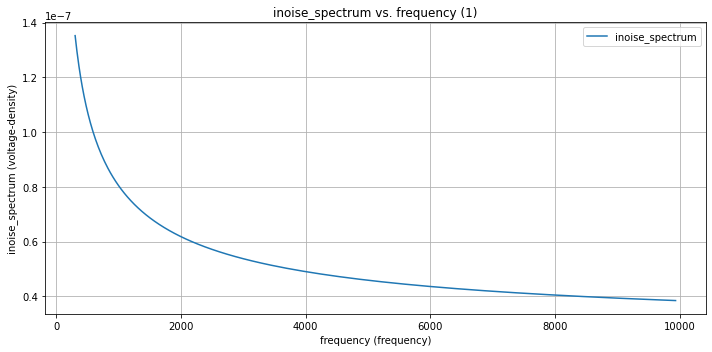

In [7]:
# Specify the path to your .raw file
filepath = '../../netlist/tb_inv_sky130_a_noise_spectrum_v3.raw'

arrs, plots = rawread(filepath)
plot_dynamic(arrs, plots, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=True, num_plots=1)

## DC analysis

In [8]:

filepath = '../../netlist/tb_inv_sky130_a_DC_v3.raw'
arrs, plots = rawread(filepath)
plot_dynamic(arrs, plots, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False)
for data, meta in zip(arrs, plots):
    x_data = data['v(v-sweep)']  # Assuming this is your x-axis data name
    y_data = data['v(out)']  # Assuming this is your y-axis data name
        
    # Find indices where v(out) approximately equals v(v-sweep)
    # Using np.isclose to handle floating-point precision issues
    indices = np.where(np.isclose(x_data, y_data, atol=1e-5))[0]
        
    if indices.size > 0:
        for index in indices:
            print(f"v(out) equals v(v-sweep) at v = {x_data[index]:.5f} V")
    else:
        print("No points found where v(out) equals v(v-sweep)")
    y_data = data['v(vg1)']
    print(f"vg1 = {y_data[index]:.5f} V")
    y_data = data['v(vg2)']
    print(f"vg2 = {y_data[index]:.5f} V")
    y_data = data['v(vs1)']
    print(f"vs1 = {y_data[index]:.5f} V")
    print(f"vs2 = {x_data[index]:.5f} V")
    

## AC analysis

/Users/miguelcorrea/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


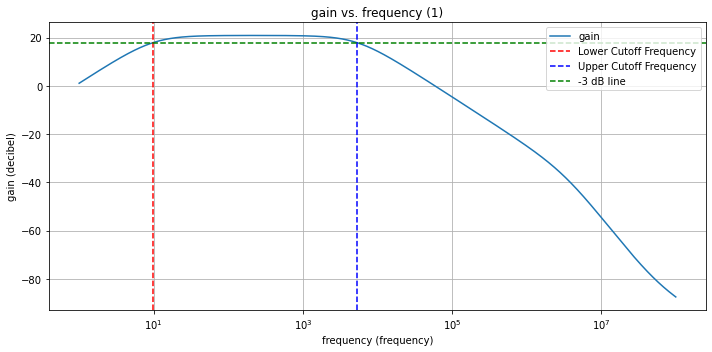

The peak gain is: 20.908144256349438 dB
The lower cutoff frequency is: 9.727472237769136 Hz
The upper cutoff frequency is: 5345.643593968647 Hz


In [ ]:
arrs, plots = rawread('../../netlist/tb_inv_sky130_a_AC_v3.raw')
peak_gain, lower_cutoff_frequency_sim, upper_cutoff_frequency_sim = plot_dynamic(arrs, plots, x_scale='log', y_scale='linear', is_data_in_dB=True, mark_cutoff=True, num_plots=1)
print(f"The peak gain is: {peak_gain} dB")
print(f"The lower cutoff frequency is: {lower_cutoff_frequency_sim} Hz")
print(f"The upper cutoff frequency is: {upper_cutoff_frequency_sim} Hz")

## Power (and trans) simulation

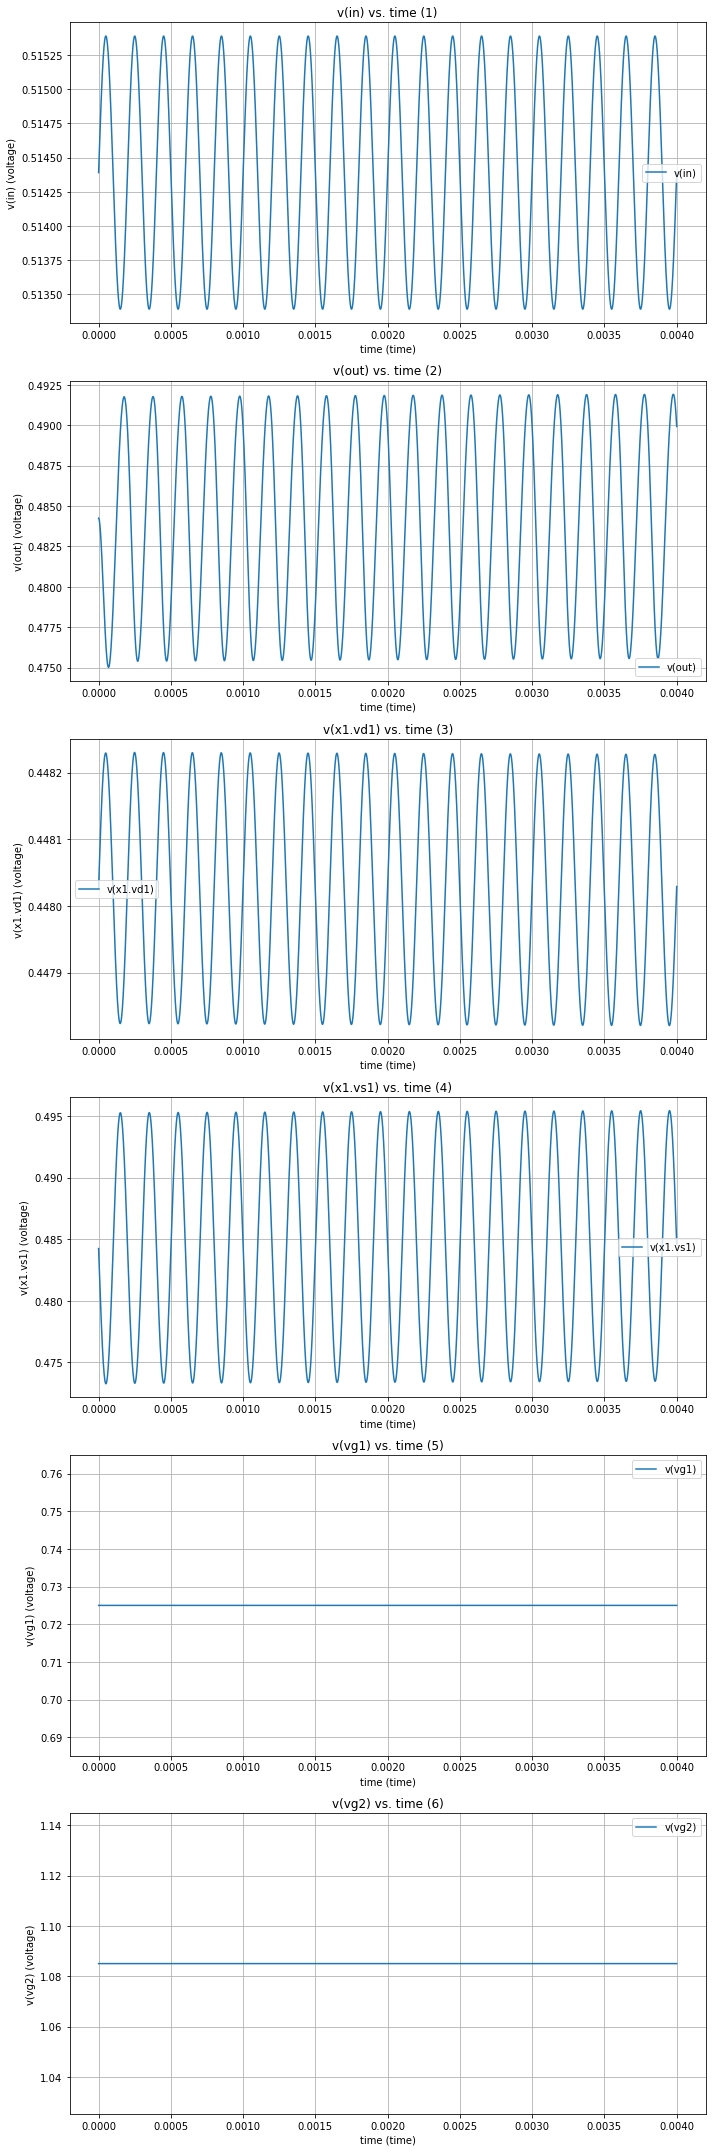

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_tran_v3.raw'  # Update to your .raw file path

arrs, plots = rawread(filepath)
plot_dynamic(arrs, plots, x_scale='linear', y_scale='linear', is_data_in_dB=False, mark_cutoff=False, num_plots=6)

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_tran_v3.raw'  # Update to your .raw file path

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()
avg_pw_total = lt.get_data('avg_pw_total')[0]*1e6  # Convert to uW
print(f"The average power is: {abs(avg_pw_total)} uW")

[Warning] Variable data type is detected as double precision.
The average power is: 3.1152599999999997 uW


#### Results of simulation summary

In [ ]:
# Here I will store my real simulation outputs
# order: gain (in dB), cut-off, noise, power
results_sim = np.array([peak_gain.real, lower_cutoff_frequency_sim.real,upper_cutoff_frequency_sim.real, inoise.real, abs(avg_pw_total.real)])
print("The results of the simulation are: ")
print(f"Gain = {results_sim[0]} dB")
print(f"Lower cut-off = {results_sim[1]} Hz")
print(f"Upper cut-off = {results_sim[2]/1e3} kHz")
print(f"Noise = {results_sim[3]} uV")
print(f"Power = {results_sim[4]} uW")

The results of the simulation are: 
Gain = 20.908144256349438 dB
Lower cut-off = 9.727472237769136 Hz
Upper cut-off = 5.3456435939686475 kHz
Noise = 5.698832087837041 uV
Power = 3.1152599999999997 uW


## Other simulation results

In [ ]:
if store_sim == True:
    with open('param_values_v3.txt', 'ab') as f:  # 
        np.savetxt(f, param_values, fmt='%e', delimiter=',')
    with open('results_sim_v3.txt', 'ab') as f:  # 
        np.savetxt(f, results_sim, fmt='%e', delimiter=',')

In [ ]:
# Load data from text files
loaded_param_values = np.loadtxt('param_values_v3.txt', delimiter=',')
loaded_results_sim = np.loadtxt('results_sim_v3.txt', delimiter=',')

# Calculate the number of simulations based on the expected structure
num_simulations_params = loaded_param_values.size // 20  # Assuming 20 parameters per simulation
num_simulations_sim = loaded_results_sim.size // 5     # Assuming 5 simulated results per simulation

# Reshape arrays to match the number of simulations and parameters
loaded_param_values = loaded_param_values.reshape(num_simulations_params, 20)
loaded_results_sim = loaded_results_sim.reshape(num_simulations_sim, 5)


# Create DataFrames from the reshaped arrays
# order: Vdd, Wn, Ln, Wp, Lp, R1_Wn, R1_Ln, R1_Vgs, R2_Wn, R2_Ln, R2_Vgs, Wc1, Lc1, MFc1, C_1, Wc2, Lc2, Mfc2, C_2, Vdc
df_parameters = pd.DataFrame(loaded_param_values, columns=['Vdd', 'Wn', 'Ln', 'Wp', 'Lp', 'R1_Wn', 'R1_Ln', 'R1_Vg',
                                                           'R2_Wn', 'R2_Ln', 'R2_Vg','Wc1', 'Lc1',
                                                            'MFc1', 'C1 (in pF)', 'Wc2', 'Lc2', 'MFc2', 
                                                            'C2 (in pF)', 'Vdc (in mV)'])

df_simulated_results = pd.DataFrame(loaded_results_sim, columns=['gain (in dB)', 'lower cut-off frequency (in Hz)','upper cut-off frequency (in Hz)', 'noise in (uV)', 'power (in uW)'])

df_complete_simulation_results = pd.concat([df_parameters, df_simulated_results], axis=1)

df_complete_simulation_results['C1 (in pF)'] = df_complete_simulation_results['C1 (in pF)'] * 1e12
df_complete_simulation_results['C2 (in pF)'] = df_complete_simulation_results['C2 (in pF)'] * 1e12
df_complete_simulation_results['Vdc (in mV)'] = df_complete_simulation_results['Vdc (in mV)'] * 1e3

df_complete_simulation_results.to_csv('complete_simulation_results_v3.csv', index=False)

df_complete_simulation_results

,Vdd,Wn,Ln,Wp,Lp,R1_Wn,R1_Ln,R1_Vg,R2_Wn,R2_Ln,...,Wc2,Lc2,MFc2,C2 (in pF),Vdc (in mV),gain (in dB),lower cut-off frequency (in Hz),upper cut-off frequency (in Hz),noise in (uV),power (in uW)
0,1.125,250.0,1.0,200.0,0.25,0.5,0.15,0.714,0.5,0.15,...,50.0,50.0,1.0,5.0380,514.39,20.89119,3.732502,9527.962,5.459399,3.089187
1,1.125,250.0,1.0,200.0,0.25,0.5,0.15,0.714,0.5,0.15,...,20.0,20.0,1.0,0.8152,514.39,20.89180,3.732502,18450.150,6.092658,3.089179
2,1.125,250.0,1.0,200.0,0.25,0.5,0.15,0.725,0.5,0.15,...,50.0,50.0,1.0,5.0380,514.39,20.91812,9.749896,14487.720,5.358833,3.115257
3,1.125,250.0,1.0,200.0,0.25,0.5,0.15,0.725,0.5,0.15,...,50.0,50.0,1.0,5.0380,514.39,20.90814,9.727472,5345.644,5.698832,3.115260
